In [1]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [2]:
pip install patchify

In [3]:
pip install segmentation-models

     |████████████████████████████████| 50 kB 5.4 MB/s 


In [35]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import scipy.io
import cv2
import os
from patchify import patchify
import segmentation_models as sm
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import jaccard_score, accuracy_score, confusion_matrix
from segmentation_models.metrics import f1_score,IOUScore
import seaborn as sns

In [ ]:
!wget https://warwick.ac.uk/fac/cross_fac/tia/data/hovernet/consep.zip
!unzip consep.zip

Reading data:

In [6]:
train_path = "/content/CoNSeP/Train"
num_of_big_images = len( os.listdir(train_path + "/Images") )
train_big_images = []
train_big_labels = []
for i in range(num_of_big_images):
  path_to_img = train_path + "/Images/train_" + str(i+1) + ".png"
  img = cv2.imread(path_to_img)
  train_big_images.append(img)
  path_to_label = train_path + "/Labels/train_" + str(i+1) + ".mat"
  mat = scipy.io.loadmat(path_to_label)["type_map"]
  mat = mat.astype("int32")
  train_big_labels.append(mat)
train_big_images = np.array(train_big_images)
train_big_labels = np.array(train_big_labels)

sarenity **check**

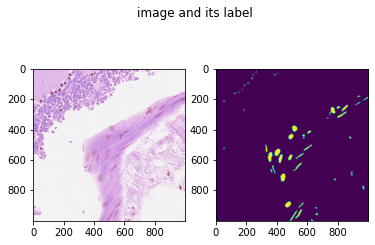

In [7]:
n = 26
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('image and its label')
ax1.imshow(train_big_images[n])
ax2.imshow(train_big_labels[n])

Dividing the image into patches with size 256*256(appropriate for resnet):

In [8]:
all_img_patches = []
for img in range(train_big_images.shape[0]):     
    large_image = train_big_images[img]
    
    patches_img = patchify(large_image, (256, 256,3), step=248)  #Step=256 for 256 patches means no overlap
    

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            
            single_patch_img = patches_img[i,j,:,:,:]
            single_patch_img = (single_patch_img.astype('float32')) / 255.
            all_img_patches.append(single_patch_img)

images = np.array(all_img_patches)
images = images.squeeze(axis=1)

In [9]:
all_mask_patches = []
for img in range(train_big_labels.shape[0]):     
    large_mask = train_big_labels[img]
    
    patches_mask = patchify(large_mask, (256, 256), step=248)
    

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):
            
            single_patch_mask = patches_mask[i,j,:,:]            
            all_mask_patches.append(single_patch_mask)

masks = np.array(all_mask_patches)

In [10]:
test_path = "/content/CoNSeP/Test"
num_of_big_images = len( os.listdir(test_path + "/Images") )
test_big_images = []
test_big_labels = []
for i in range(num_of_big_images):
  path_to_img = test_path + "/Images/test_" + str(i+1) + ".png"
  img = cv2.imread(path_to_img)
  test_big_images.append(img)
  path_to_label = test_path + "/Labels/test_" + str(i+1) + ".mat"
  mat = scipy.io.loadmat(path_to_label)["type_map"]
  mat = mat.astype("int32")
  test_big_labels.append(mat)
test_big_images = np.array(test_big_images)
test_big_labels = np.array(test_big_labels)

In [11]:
all_img_patches = []
for img in range(test_big_images.shape[0]):     
    large_image = test_big_images[img]
    
    
    patches_img = patchify(large_image, (256, 256,3), step=248)  #Step=256 for 256 patches means no overlap
    

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            
            single_patch_img = patches_img[i,j,:,:,:]
            single_patch_img = (single_patch_img.astype('float32')) / 255.
            all_img_patches.append(single_patch_img)

test_images = np.array(all_img_patches)
test_images = test_images.squeeze(axis=1)

In [12]:
all_mask_patches = []
for img in range(test_big_labels.shape[0]):
     
    large_mask = test_big_labels[img]
    
    patches_mask = patchify(large_mask, (256, 256), step=248)  
    

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):
            
            single_patch_mask = patches_mask[i,j,:,:]            
            all_mask_patches.append(single_patch_mask)

test_masks = np.array(all_mask_patches)

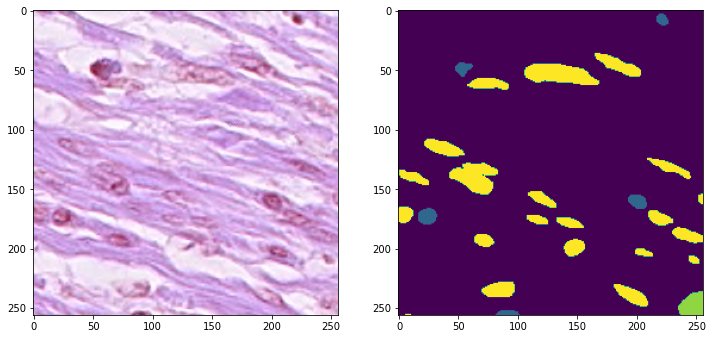

In [13]:
#sarinity check
import random
image_number = random.randint(0, images.shape[0])
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(images[image_number])
plt.subplot(122)
plt.imshow(np.reshape(masks[image_number], (256, 256)))
plt.show()

Preparing data generator:

In [14]:
def myPreprocessing (x):
  make_int = np.round(x).astype(x.dtype)
  return make_int

img_data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
                     zoom_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect')

mask_data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
                     zoom_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect',
                     preprocessing_function = myPreprocessing) #Binarize the output again.


                     

In [15]:
BACKBONE = 'resnet34'
preprocess_input1 = sm.get_preprocessing(BACKBONE)
X_train=preprocess_input1(images)
print(X_train.shape)

(432, 256, 256, 3)


In [16]:
BACKBONE = 'resnet34'
preprocess_input1 = sm.get_preprocessing(BACKBONE)
X_test=preprocess_input1(test_images)
print(X_test.shape)

(224, 256, 256, 3)


In [17]:
seed = 24
image_data_generator = ImageDataGenerator(**img_data_gen_args)
image_data_generator.fit(X_train, augment=True, seed=seed)

image_generator = image_data_generator.flow(X_train, seed=seed)
valid_img_generator = image_data_generator.flow(X_test, seed=seed)

mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
mask_data_generator.fit(np.expand_dims(masks,axis=-1), augment=True, seed=seed)
mask_generator = mask_data_generator.flow(np.expand_dims(masks,axis=-1), seed=seed)
valid_mask_generator = mask_data_generator.flow(np.expand_dims(test_masks,axis=-1), seed=seed)

In [18]:

def my_image_mask_generator(image_generator, mask_generator):
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        yield (img, to_categorical( mask,num_classes=8))

my_generator = my_image_mask_generator(image_generator, mask_generator)

validation_datagen = my_image_mask_generator(valid_img_generator, valid_mask_generator)

In [29]:
model = sm.Unet(BACKBONE, encoder_weights='imagenet',classes=8,activation='softmax')
model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score, sm.metrics.f1_score, keras.metrics.Accuracy()])
print(model.summary())

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, None, None,  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 3 9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_204 (ZeroPadding (None, None, None, 3 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 9408        zero_padding2d_204[0][0]         
___________________________________________________________________________________________

In [30]:
history = model.fit(my_generator, steps_per_epoch=50, validation_steps=50, epochs=30, validation_data=validation_datagen)

Epoch 1/30
50/50 [==============================] - 146s 2s/step - loss: 1.1657 - iou_score: 0.1348 - f1-score: 0.1835 - accuracy: 0.0000e+00 - val_loss: 2053.2498 - val_iou_score: 0.1088 - val_f1-score: 0.1204 - val_accuracy: 0.9475
Epoch 2/30
50/50 [==============================] - 150s 3s/step - loss: 0.8792 - iou_score: 0.2301 - f1-score: 0.2976 - accuracy: 0.0000e+00 - val_loss: 1.2660 - val_iou_score: 0.0667 - val_f1-score: 0.1030 - val_accuracy: 0.0000e+00
Epoch 3/30
50/50 [==============================] - 150s 3s/step - loss: 0.8142 - iou_score: 0.2757 - f1-score: 0.3596 - accuracy: 0.0000e+00 - val_loss: 1.1166 - val_iou_score: 0.0994 - val_f1-score: 0.1142 - val_accuracy: 0.0000e+00
Epoch 4/30
50/50 [==============================] - 109s 2s/step - loss: 0.7761 - iou_score: 0.3098 - f1-score: 0.4035 - accuracy: 3.7253e-09 - val_loss: 1.1387 - val_iou_score: 0.0988 - val_f1-score: 0.1110 - val_accuracy: 0.0000e+00
Epoch 5/30
50/50 [==============================] - 109s 2s/s

In [31]:
predicted_mask = np.argmax( model.predict(X_test), axis=3 )

In [32]:
accuracy_score(predicted_mask.flatten(),test_masks.flatten())

0.8735632215227399

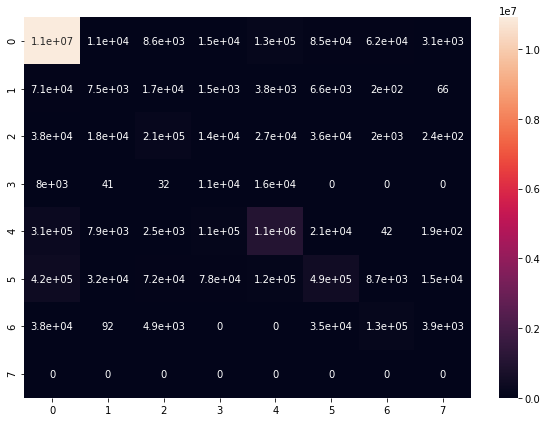

In [39]:
confMat = confusion_matrix(predicted_mask.flatten(),test_masks.flatten())
plt.figure(figsize = (10,7))
sns.heatmap(confMat, annot=True)